# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [17]:
import os
import sys
import random
import math
import re
import h5py
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("/g/data1a/kl02/jss548/libs/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import hail

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#path to weights
HAIL_WEIGHTS_PATH = "/g/data1a/kl02/jss548/hail-research/HailPixel/mask-rcnn/mask_rcnn_hail_final.h5"  # TODO: update this path

## Configurations

In [19]:
config = hail.HailConfig()
HAIL_DIR = os.path.join(ROOT_DIR, "datasets/hail")

In [20]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        150
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [21]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [22]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [23]:
# Load validation dataset
dataset = hail.HailDataset()
dataset.load_hail(HAIL_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3
Classes: ['BG', 'hail']


## Load Model

In [24]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [25]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = HAIL_WEIGHTS_PATH #model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /g/data1a/kl02/jss548/hail-research/HailPixel_imagery/mask-rcnn/mask_rcnn_hail_final.h5


## Run Detection

image ID: hail.0556.png (0) /g/data1a/kl02/jss548/libs/Mask_RCNN/datasets/hail/val/0556.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (123,)                min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (123, 4)              min:  113.00000  max:  911.00000  int32
gt_mask                  shape: (1024, 1024, 123)     min:    0.00000  max:    1.00000  bool
number of hits 112
number of GT missed 7
number of new points 11


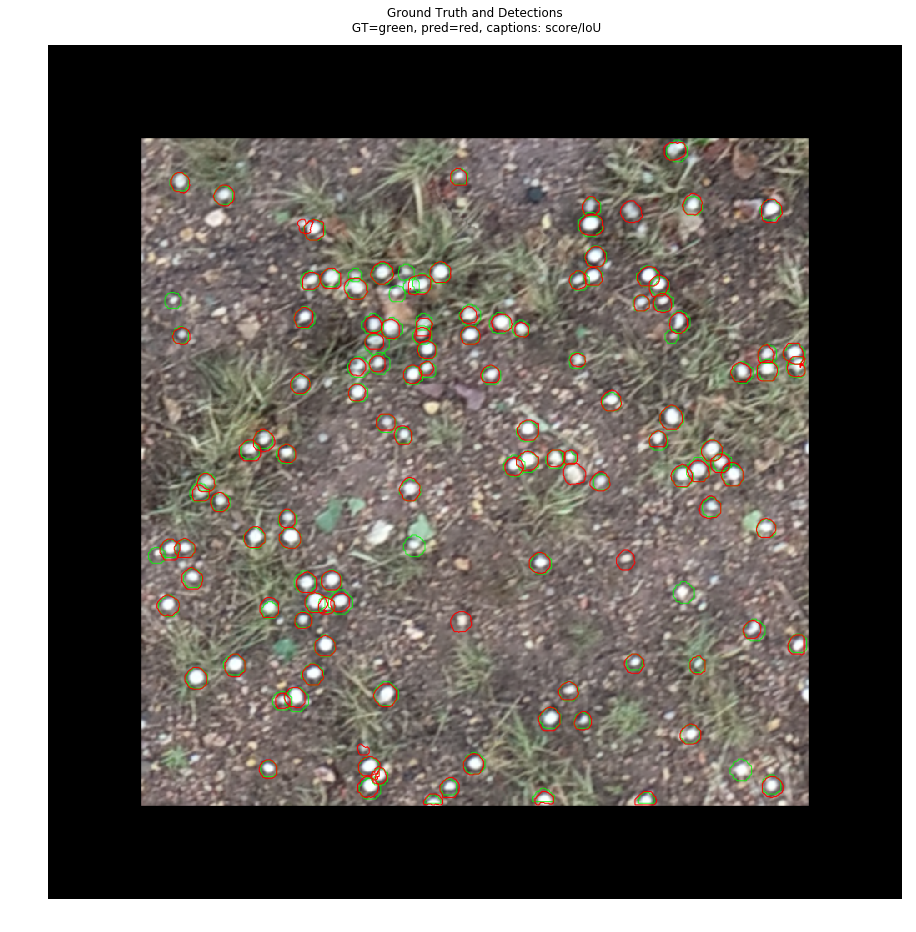

In [56]:
image_id = 0#random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_differences(image,
                        gt_bbox, gt_class_id, gt_mask,
                        r['rois'], r['class_ids'], r['scores'], r['masks'],
                        dataset.class_names, ax=ax,
                        show_mask=False, show_box=False,
                        iou_threshold=0.5, score_threshold=0.5)

gt_match, pred_match, overlaps = utils.compute_matches(
        gt_bbox, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        iou_threshold=0.5, score_threshold=0.5)


log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#overlap array
#dim0: prediction
#dim1: ground truth

overlap_gt = np.sum(overlaps>0.5,axis=1)
overlap_pd = np.sum(overlaps>0.5,axis=0)

hits_gt = np.sum(overlap_gt)
missed  = len(overlap_gt) - hits_gt
hits_pd = np.sum(overlap_pd)
new     = len(overlap_pd) - hits_pd

print('number of hits',hits_gt)
print('number of GT missed',missed)
print('number of new points',new)

image ID: hail.0710.png (1) /g/data1a/kl02/jss548/libs/Mask_RCNN/datasets/hail/val/0710.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (84,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (84, 4)               min:  113.00000  max:  909.00000  int32
gt_mask                  shape: (1024, 1024, 84)      min:    0.00000  max:    1.00000  bool
number of hits 75
number of GT missed 4
number of new points 9


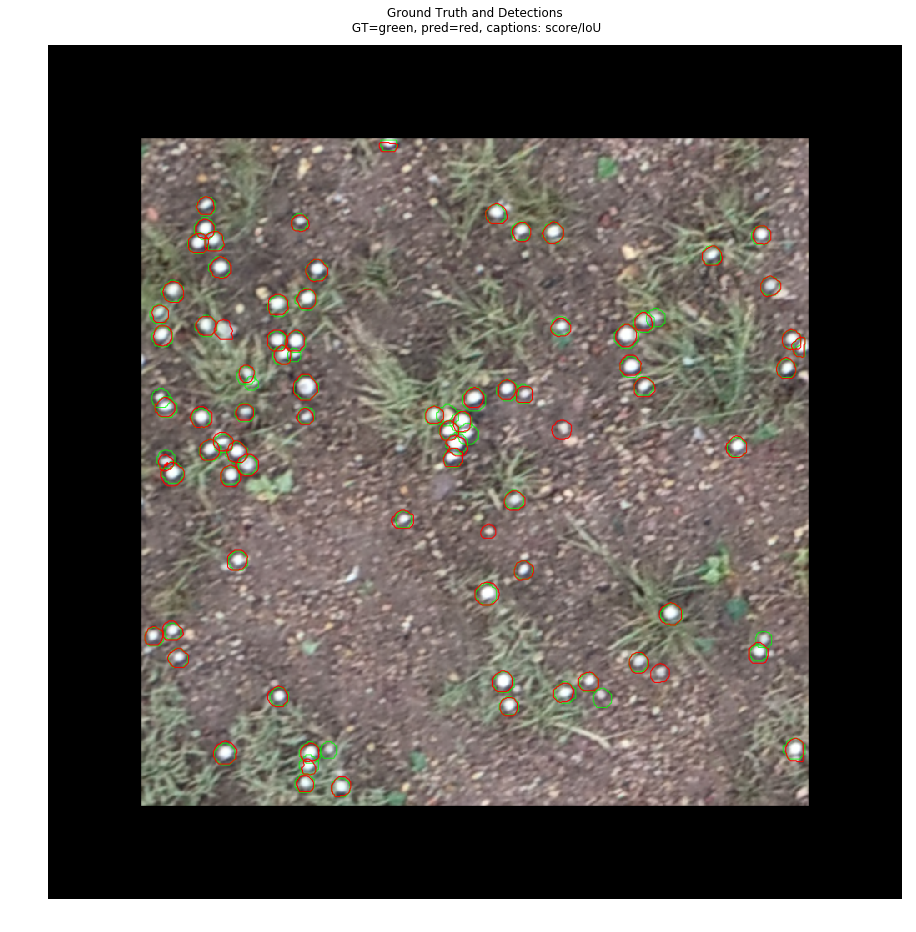

In [62]:
image_id = 1#random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_differences(image,
                        gt_bbox, gt_class_id, gt_mask,
                        r['rois'], r['class_ids'], r['scores'], r['masks'],
                        dataset.class_names, ax=ax,
                        show_mask=False, show_box=False,
                        iou_threshold=0.5, score_threshold=0.5)

gt_match, pred_match, overlaps = utils.compute_matches(
        gt_bbox, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        iou_threshold=0.5, score_threshold=0.5)


log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#overlap array
#dim0: prediction
#dim1: ground truth

overlap_gt = np.sum(overlaps>0.5,axis=1)
overlap_pd = np.sum(overlaps>0.5,axis=0)

hits_gt = np.sum(overlap_gt)
missed  = len(overlap_gt) - hits_gt
hits_pd = np.sum(overlap_pd)
new     = len(overlap_pd) - hits_pd

print('number of hits',hits_gt)
print('number of GT missed',missed)
print('number of new points',new)

image ID: hail.1254.png (2) /g/data1a/kl02/jss548/libs/Mask_RCNN/datasets/hail/val/1254.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (108,)                min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (108, 4)              min:  113.00000  max:  911.00000  int32
gt_mask                  shape: (1024, 1024, 108)     min:    0.00000  max:    1.00000  bool
number of hits 97
number of GT missed 12
number of new points 11


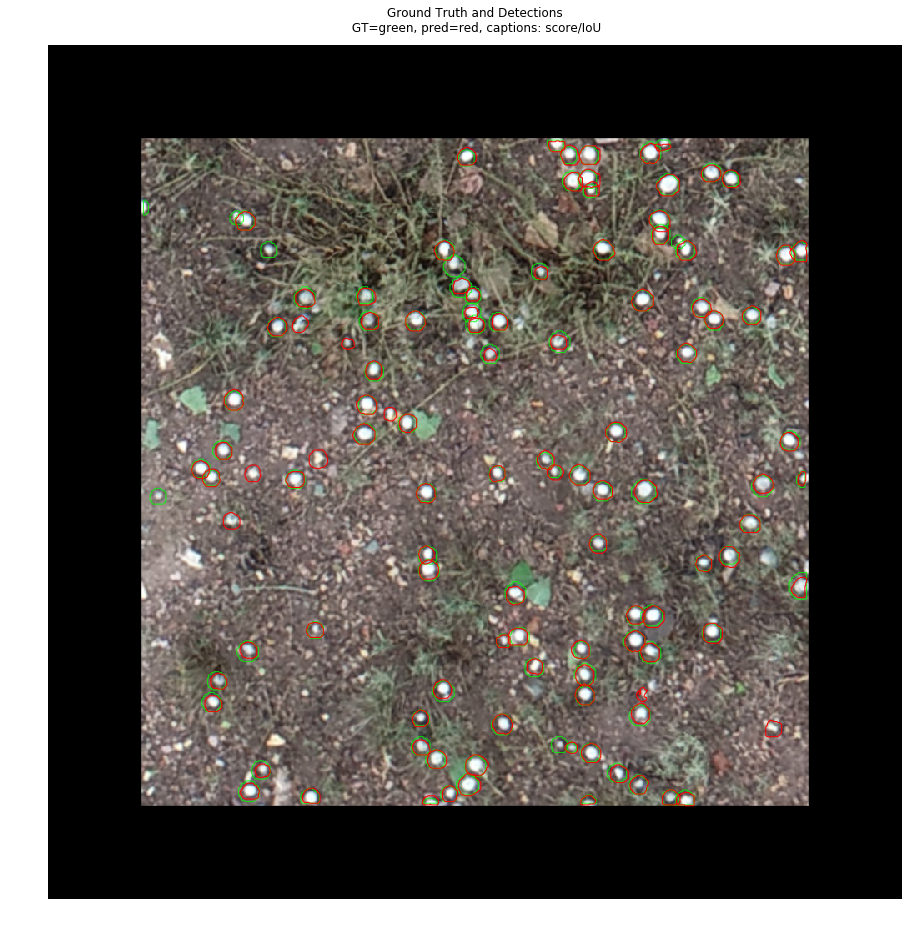

In [58]:
image_id = 2#random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_differences(image,
                        gt_bbox, gt_class_id, gt_mask,
                        r['rois'], r['class_ids'], r['scores'], r['masks'],
                        dataset.class_names, ax=ax,
                        show_mask=False, show_box=False,
                        iou_threshold=0.5, score_threshold=0.5)

gt_match, pred_match, overlaps = utils.compute_matches(
        gt_bbox, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        iou_threshold=0.5, score_threshold=0.5)


log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#overlap array
#dim0: prediction
#dim1: ground truth

overlap_gt = np.sum(overlaps>0.5,axis=1)
overlap_pd = np.sum(overlaps>0.5,axis=0)

hits_gt = np.sum(overlap_gt)
missed  = len(overlap_gt) - hits_gt
hits_pd = np.sum(overlap_pd)
new     = len(overlap_pd) - hits_pd

print('number of hits',hits_gt)
print('number of GT missed',missed)
print('number of new points',new)